In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from transformers import AutoTokenizer
from transformers import PreTrainedTokenizerFast
from typing import Dict, Tuple
from transformers import AutoModelForSequenceClassification
from peft import PeftModel


In [2]:
def evaluate_llm_classifier(base_model_path: str, lora_adapter_path: str, test_data: pd.DataFrame, tokenizer: PreTrainedTokenizerFast) -> Tuple[Dict[str, float | int], Dict[str, float]]:

    base_model = AutoModelForSequenceClassification.from_pretrained(
        base_model_path,
        torch_dtype=torch.bfloat16,
        device_map="auto",
        num_labels=2
    )

    model = PeftModel.from_pretrained(
        base_model,
        lora_adapter_path,
        torch_dtype=torch.bfloat16,
        device_map="auto"
    )

    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.eos_token_id

    tokenizer.chat_template = None

    tokenizer.chat_template = """<|begin_of_text|>{% for message in messages %}<|start_header_id|>{{ message['role'] }}<|end_header_id|>{{ message['content'] }}<|eot_id|>{% endfor %}"""

    true_labels = []
    predicted_labels = []

    for _, row in test_data.iterrows():
        messages = [
            {"role": "system", "content": row["system"]},
            {"role": "user", "content": row["user"]},
        ]

        prompt = tokenizer.apply_chat_template(messages, tokenize=False)

        inputs = tokenizer(
            prompt,
            return_tensors="pt",
            padding='max_length',
            truncation=True,
            max_length=512
        ).to(model.device)

        with torch.no_grad():
            outputs = model(**inputs)

            logits = outputs.logits
            predictions = torch.softmax(logits, dim=-1)
            predicted_class = torch.argmax(predictions, dim=-1)

        pred_label = bool(predicted_class[0])
        true_label = row["assistant"]

        true_labels.append(true_label)
        predicted_labels.append(pred_label)

    metrics = {
        "accuracy": accuracy_score(true_labels, predicted_labels),
        "precision": precision_score(true_labels, predicted_labels),
        "recall": recall_score(true_labels, predicted_labels),
        "f1_score": f1_score(true_labels, predicted_labels),
        "true_labels": true_labels,
        "predicted_labels": predicted_labels,
    }

    evaluation_confusion_matrix = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10,8))
    sns.heatmap(evaluation_confusion_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

    return metrics

In [3]:
test_df = pd.read_csv("../processed_data/test.csv")

In [4]:
base_model_path = "../models/llama_models/llama-3.2-3B"

In [5]:
lora_adapter_path = "../models/tuned_models/llama-3.2-3B-phishing-classifier-seq-cls"

In [6]:
tokenizer = AutoTokenizer.from_pretrained(base_model_path, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at ../models/llama_models/llama-3.2-3B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


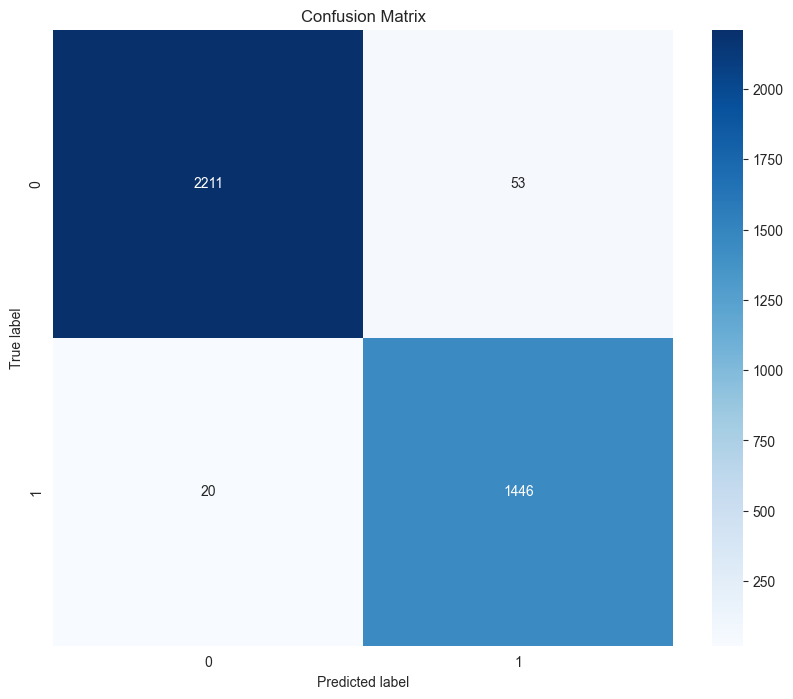

In [7]:
metrics = evaluate_llm_classifier(
    base_model_path=base_model_path,
    lora_adapter_path=lora_adapter_path,
    test_data=test_df,
    tokenizer=tokenizer
)

In [8]:
print(f"Accuracy: {metrics['accuracy']}")
print(f"Precision: {metrics['precision']}")
print(f"Recall: {metrics['recall']}")
print(f"F1-score: {metrics['f1_score']}")


Accuracy: 0.9804289544235925
Precision: 0.9646430953969313
Recall: 0.9863574351978172
F1-score: 0.9753794266441821
